In [1]:
%pylab inline
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

import autometacal
import tensorflow as tf
import galsim

Populating the interactive namespace from numpy and matplotlib


## Creating some data

In [2]:
# let's try to do shape measurement using weigthed moments
nx = 45
ny = 45
XX=np.zeros((nx,ny))
XY=np.zeros((nx,ny))
YY=np.zeros((nx,ny))
w = np.zeros((nx,ny))
sigma=5

for i in range(0,nx):
    x=0.5+i-(nx)/2.0
    for j in range(0,ny):
        y=0.5+j-(ny)/2.0
        XX[i,j]=x*x
        XY[i,j]=x*y
        YY[i,j]=y*y
        w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                               (2 * sigma ** 2))

def get_ellipticity(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    norm = tf.reduce_sum(w*img)
    Q11 = tf.reduce_sum(w*img*YY)/norm
    Q12 = tf.reduce_sum(w*img*XY)/norm
    Q21 = Q12
    Q22 = tf.reduce_sum(w*img*XX)/norm
    
    q1 = Q11 - Q22
    q2 = 2*Q12
    
    T= Q11 + Q22  + 2*tf.sqrt(Q11*Q22 - Q12**2)
    return q1/T, q2/T

In [3]:
noise_level = 2e-3

ref_gal = galsim.Exponential(half_light_radius=1.5).shear(g1=0.2,g2=0.1)
ref_psf = galsim.Moffat(beta=2.5, fwhm=0.9)
ref_reconv_psf = galsim.Moffat(beta=2.5, fwhm=1.)

gal = galsim.Convolve([ref_gal, ref_psf]).drawImage(nx=45,ny=45, scale=0.263).array[np.newaxis]
psf = ref_psf.drawImage(nx=45,ny=45, scale=0.263).array[np.newaxis]
reconv_psf = ref_reconv_psf.drawImage(nx=45,ny=45, scale=0.263).array[np.newaxis]

img0 = noise_level*tf.random.normal(shape=[1,45,45])

Text(0.5, 1.0, 'True Galaxy')

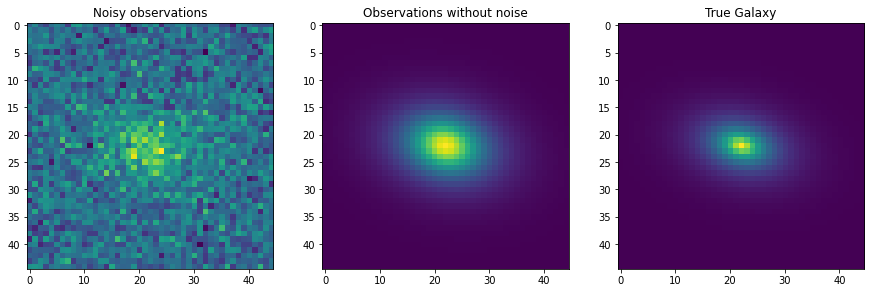

In [4]:
figure(figsize=[15,5])
subplot(131)
imshow(img0[0]+gal[0])
title('Noisy observations')
subplot(132)
imshow(gal[0])
title('Observations without noise')
subplot(133)
imshow(ref_gal.drawImage(nx=45,ny=45, scale=0.263).array)
title('True Galaxy')

## Measuring response 

In [5]:
# Step I, let's measure the total response on this galaxy, without any noise
@tf.function
def get_response(img, noise):
    img = tf.convert_to_tensor(img)
    noise = tf.convert_to_tensor(noise)
    g = tf.zeros([1,2])
    with tf.GradientTape() as tape:
        tape.watch(g)
        mcal = autometacal.generate_mcal_image(img, psf, reconv_psf, g)
        mcal_noise = autometacal.generate_mcal_image(noise, psf, reconv_psf, tf.zeros([1,2]))
        mcal = mcal + mcal_noise
        e = tf.reshape(get_ellipticity(mcal[0]), [1,2])
    res = tape.batch_jacobian(e,g)
    return mcal, e, res

In [6]:
# This is the response if we had an image without any noise
ir, er, Rr = get_response(gal, 0*img0)
er, Rr

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.06494457, 0.03247015]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[ 3.5876793e-01, -1.9329786e-04],
         [-8.0222562e-03,  2.9750362e-01]]], dtype=float32)>)

Now we add noise but, the noise is not sheared

In [7]:
Rrs = []
for i in range(5000):
    img = noise_level*tf.random.normal(shape=[1,45,45])
    i, e, R = get_response(gal, img)
    Rrs.append(R[0])
Rrs = np.stack(Rrs, axis=0)

mean: 0.0017351791 0.0013033198
%bias: 0.4836494568735361 0.4380853846669197
error on mean: 1.1126622557640076e-05 8.852962404489517e-06


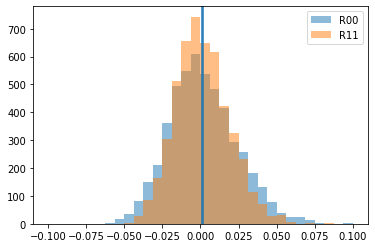

In [8]:
hist(Rrs[:,0,0] - Rr[0,0,0].numpy(),32, label='R00', range=[-0.1,0.1], alpha=0.5);
hist(Rrs[:,1,1] - Rr[0,1,1].numpy(),32, label='R11', range=[-0.1,0.1], alpha=0.5);

legend()
axvline(mean(Rrs[:,0,0] - Rr[0,0,0].numpy()))
axvline(mean(Rrs[:,1,1] - Rr[0,1,1].numpy()))
print("mean:",mean(Rrs[:,0,0] - Rr[0,0,0].numpy()), mean(Rrs[:,1,1] - Rr[0,1,1].numpy()))
print("%bias:",mean(Rrs[:,0,0] - Rr[0,0,0].numpy())/Rr[0,0,0].numpy()*100, 
               mean(Rrs[:,1,1] - Rr[0,1,1].numpy())/Rr[0,1,1].numpy()*100)
print("error on mean:",std(Rrs[:,0,0] - Rr[0,0,0].numpy())/sqrt(2000), std(Rrs[:,1,1] - Rr[0,1,1].numpy())/sqrt(2000))

mean: 2.4152954e-05 -5.619184e-05
%bias: -0.3010743297636509 29.0700763463974
error on mean: 6.957598961889744e-07 1.4565855963155628e-06


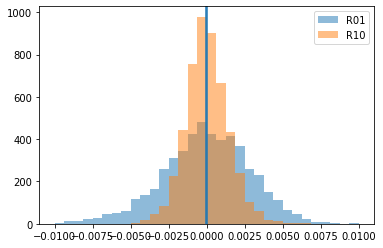

In [9]:
hist(Rrs[:,0,1] - Rr[0,0,1].numpy(),32, label='R01', range=[-0.01,0.01], alpha=0.5);
hist(Rrs[:,1,0] - Rr[0,1,0].numpy(),32, label='R10', range=[-0.01,0.01], alpha=0.5);

legend()
axvline(mean(Rrs[:,1,0] - Rr[0,1,0].numpy()))
axvline(mean(Rrs[:,0,1] - Rr[0,0,1].numpy()))
print("mean:",mean(Rrs[:,1,0] - Rr[0,1,0].numpy()), mean(Rrs[:,0,1] - Rr[0,0,1].numpy()))
print("%bias:",mean(Rrs[:,1,0] - Rr[0,1,0].numpy())/Rr[0,1,0].numpy()*100, 
               mean(Rrs[:,0,1] - Rr[0,0,1].numpy())/Rr[0,0,1].numpy()*100)
print("error on mean:",std(Rrs[:,1,0] - Rr[0,1,0].numpy())/sqrt(2000), std(Rrs[:,0,1] - Rr[0,0,1].numpy())/sqrt(2000)

In [10]:
# So, this will become our reference response matrix, the one that would be true if the noise was indeed added
# after the shearing operation on the sky
mR = Rrs.mean(axis=0)

In [11]:
# And it should be different from the one without any noise
mR, Rr[0]

(array([[ 3.6050314e-01, -2.4948959e-04],
        [-7.9981163e-03,  2.9880735e-01]], dtype=float32),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 3.5876793e-01, -1.9329786e-04],
        [-8.0222562e-03,  2.9750362e-01]], dtype=float32)>)

Very interestingly, in this case at least, the noise only seems to affect the diagonal part of the response matrix

Now we add random noise on the image before shearing and compute the total response again

In [12]:
Rs = []
for i in range(2000):
    img = noise_level*tf.random.normal(shape=[1,45,45])
    i, e, R = get_response(gal+img, 0*img)
    Rs.append(R[0])
Rs = np.stack(Rs, axis=0)

Text(0.5, 1.0, 'Resiudal image')

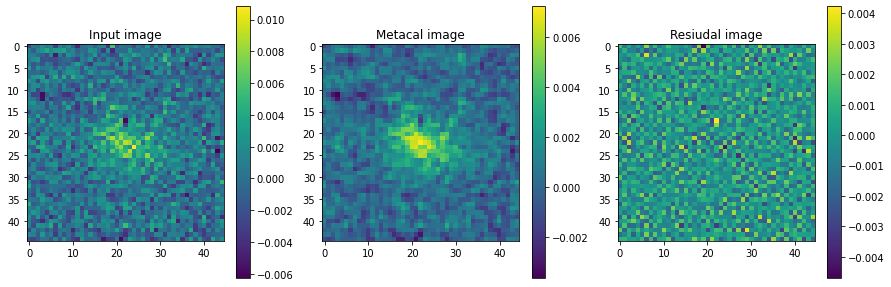

In [13]:
figure(figsize=[15,5])
subplot(131)
imshow((gal+img)[0]); colorbar()
title('Input image')
subplot(132)
imshow(i[0]); colorbar()
title('Metacal image')
subplot(133)
imshow(i[0] - (gal+img)[0]); colorbar()
title('Resiudal image')

mean: -0.0016655253 -0.0005426075
error on mean: 1.4326325617730617e-05 1.9591661170125006e-05


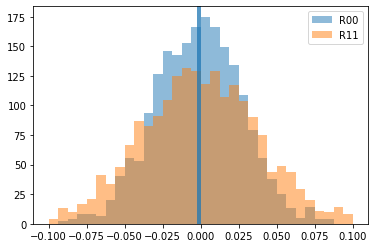

In [14]:
# Residuals with respect to a case where noise is not sheared
hist(Rs[:,0,0] - mR[0,0],32, label='R00', range=[-0.1,0.1], alpha=0.5);
hist(Rs[:,1,1] - mR[1,1],32, label='R11', range=[-0.1,0.1], alpha=0.5);

legend()
axvline(mean(Rs[:,0,0] - mR[0,0]))
axvline(mean(Rs[:,1,1] - mR[1,1]))
print("mean:",mean(Rs[:,0,0] - mR[0,0]), mean(Rs[:,1,1] - mR[1,1]))
print("error on mean:",std(Rs[:,0,0] - mR[0,0])/sqrt(2000), std(Rs[:,1,1] - mR[1,1])/sqrt(2000))

mean: 0.0010094669 0.00057751185
error on mean: 1.5088798478245735e-05 1.2460239231586456e-05


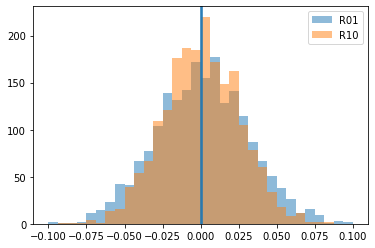

In [15]:
hist(Rs[:,0,1] - mR[0,1],32, label='R01', range=[-0.1,0.1], alpha=0.5);
hist(Rs[:,1,0] - mR[1,0],32, label='R10', range=[-0.1,0.1], alpha=0.5);

legend()
axvline(mean(Rs[:,0,1] - mR[0,1]))
axvline(mean(Rs[:,1,0] - mR[1,0]))
print("mean:",mean(Rs[:,0,1] - mR[0,1]), mean(Rs[:,1,0] - mR[1,0]))
print("error on mean:",std(Rs[:,0,1] - mR[0,1])/sqrt(2000), std(Rs[:,1,0] - mR[1,0])/sqrt(2000))

In [16]:
# This is the mean response matrix in practice from metacal without correction
mRs = Rs.mean(axis=0)

In [17]:
# Bias in percent
abs(mRs - mR)/mR*100

array([[ 4.6204355e-01, -4.0461258e+02],
       [-7.2205448e+00,  1.8157227e-01]], dtype=float32)

## Measuring bias term by term

So, we know that the Jacobian can be written as:
$$ \frac{d e}{d I} \frac{d I}{d g} = \frac{d e}{d I}(I+n) \left(\frac{d I}{d g}(I_{gal}) + \frac{d I}{d g}(n)\right)$$

Can we measure this term $\frac{d e}{d I}(I+n) \frac{d I}{d g}(n)$?

To test that, we can try to compute the first term $\frac{d e}{d I}(I+n) \frac{d I}{d g}(I_{gal})$

In [18]:
# we first need to compute dI/dg for the galaxy image
@tf.function
def get_jacobian(img):
    img = tf.convert_to_tensor(img)
    bs,nx,ny = img.shape.as_list()
    g = tf.zeros([bs,2])
    with tf.GradientTape() as tape:
        tape.watch(g)
        mcal = autometacal.generate_mcal_image(img, psf, reconv_psf, g)
    res = tape.batch_jacobian(mcal,g)
    return mcal, res

In [19]:
mcal, image_jacobian = get_jacobian(gal)

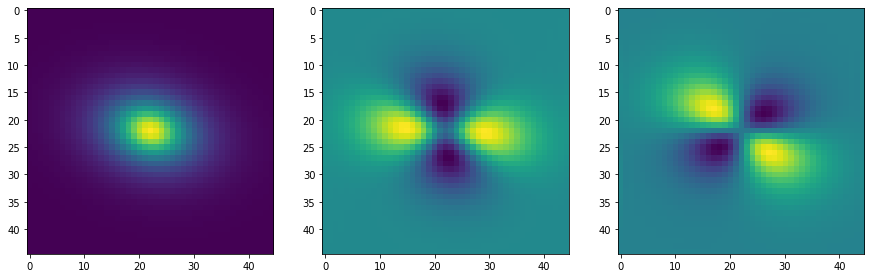

In [20]:
figure(figsize=[15,5])
subplot(131)
imshow(mcal[0])
subplot(132)
imshow(image_jacobian[0,:,:,0])
subplot(133)
imshow(image_jacobian[0,:,:,1])

In [21]:
# And we can compute the jacobian of the ellipticity measurement
@tf.function
def get_ellipticity_jacobian(img, noise):
    img = tf.convert_to_tensor(img)
    noise = tf.convert_to_tensor(noise)
    g = tf.zeros([1,2])
    with tf.GradientTape() as tape:
        tape.watch(img)
        tape.watch(noise)
        mcal = autometacal.generate_mcal_image(img, psf, reconv_psf, g)
        mcal_noise = autometacal.generate_mcal_image(noise, psf, reconv_psf, tf.zeros([1,2]))
        mcal = mcal + mcal_noise
        e = tf.reshape(get_ellipticity(mcal), [1,2])
        res = tape.batch_jacobian(e,mcal)
    return e, res

In [22]:
e, e_jacobian = get_ellipticity_jacobian(gal, 0*img0)

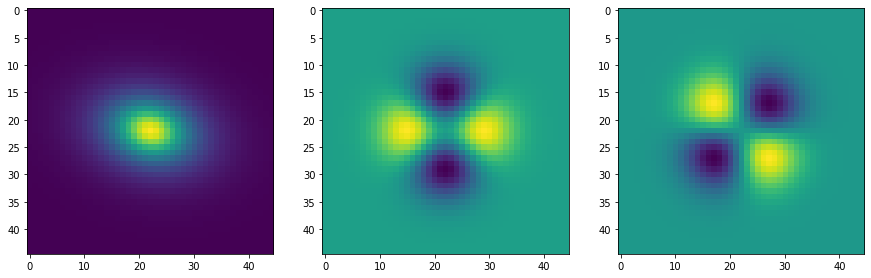

In [23]:
figure(figsize=[15,5])
subplot(131)
imshow(mcal[0])
subplot(132)
imshow(e_jacobian[0,0,:,:])
subplot(133)
imshow(e_jacobian[0,1,:,:])

In [24]:
e_jacobian.shape

TensorShape([1, 2, 45, 45])

In [25]:
image_jacobian.shape

TensorShape([1, 45, 45, 2])

In [26]:
R_manual = tf.tensordot(e_jacobian, image_jacobian, axes=[[2,3],[1,2]])

In [27]:
R_manual, Rr

(<tf.Tensor: shape=(1, 2, 1, 2), dtype=float32, numpy=
 array([[[[ 3.5876811e-01, -1.9315982e-04]],
 
         [[-8.0225430e-03,  2.9750314e-01]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[ 3.5876793e-01, -1.9329786e-04],
         [-8.0222562e-03,  2.9750362e-01]]], dtype=float32)>)

Ok, we indeed recover the correct response matrix when we compute it manually

In [43]:
# Alright, so here we will compute the noisy ellipticity jacobian, but
# assume the noise response to shear is 0
Rm = []
Rm2 = []
for i in range(5000):
    img = noise_level*tf.random.normal(shape=[1,45,45])
    _, e_jac = get_ellipticity_jacobian(gal, img)
    R = tf.tensordot(e_jac, image_jacobian, axes=[[2,3],[1,2]])
    _, _, R2 = get_response(gal, img)
    Rm.append(R[0,:,0])
    Rm2.append(R2[0])
Rm = np.stack(Rm, axis=0)
Rm2 = np.stack(Rm2, axis=0)

In [34]:
# Check that it's doing what it's supposed to

In [30]:
i, e, R_test = get_response(gal, img)

In [31]:
R_test[0] - R[0,:,0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 7.7486038e-07,  3.0547380e-07],
       [-7.9907477e-07, -4.4703484e-07]], dtype=float32)>

In [32]:
i, e, R_test = get_response(gal+ img,0*img)

In [33]:
R_test[0] - R[0,:,0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.00715941, 0.04017202],
       [0.02763738, 0.01990676]], dtype=float32)>

In [44]:
# Ok. confirmed, we are indeed computing the response only with respect to the first term

mean: 0.000639379 0.000538512
error on mean: 0.00031214048203399234 0.0002492343613397394


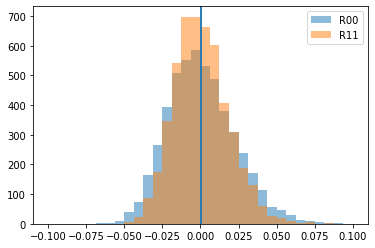

In [42]:
hist(Rm[:,0,0] - mR[0,0],32, label='R00', range=[-0.1,0.1], alpha=0.5);
hist(Rm[:,1,1] - mR[1,1],32, label='R11', range=[-0.1,0.1], alpha=0.5);

legend()
axvline(mean(Rm[:,0,0] - mR[0,0]))
axvline(mean(Rm[:,1,1] - mR[1,1]))
print("mean:",mean(Rm[:,0,0])- mR[0,0], mean(Rm[:,1,1] - mR[1,1]))
print("error on mean:",std(Rm[:,0,0] - mR[0,0])/sqrt(5000), std(Rm[:,1,1] - mR[1,1])/sqrt(5000))

mean: -7.4488626e-06 3.4620255e-06
error on mean: 2.027292553968481e-05 4.080569298588436e-05


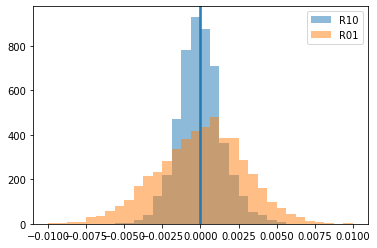

In [41]:
hist(Rm[:,1,0] - mR[1,0],32, label='R10', range=[-0.01,0.01], alpha=0.5);
hist(Rm[:,0,1] - mR[0,1],32, label='R01', range=[-0.01,0.01], alpha=0.5);

legend()
axvline(mean(Rm[:,1,0] - mR[1,0]))
axvline(mean(Rm[:,0,1] - mR[0,1]))
print("mean:",mean(Rm[:,1,0] - mR[1,0]), mean(Rm[:,0,1] - mR[0,1]))
print("error on mean:",std(Rm[:,1,0] - mR[1,0])/sqrt(5000), std(Rm[:,0,1] - mR[0,1])/sqrt(5000))

In [49]:
(Rm.mean(axis=0)- Rm2.mean(axis=0))/Rm2.mean(axis=0)

array([[-5.7800230e-07, -2.0406398e-04],
       [-2.5834472e-05,  7.9686413e-07]], dtype=float32)

In [51]:
abs(Rm.mean(axis=0) - mRs)/mRs*100

array([[  0.5820646 , 147.33824   ],
       [ -8.331478  ,   0.31229687]], dtype=float32)

## Evaluating the second term directly


In [77]:
# This will ignore the gradient with respect to the image, and just grab the gradient with respect to noise
Rns = []
Rgs = []
Rts = []
for i in range(5000):
    img = noise_level*tf.random.normal(shape=[1,45,45])
    _, _, Rn = get_response(img, gal) # Measure the de/di dI/dg(n) <- should be the source of bias
    _, _, Rg = get_response(gal, img) # Measure the de/di dI/dg(Igal) <- should be the true
    _, _, Rt = get_response(gal + img, 0*img) # Measure the de/di dI/dg(Igal+n) <- What we can measure in practice
    
    Rns.append(Rn[0])
    Rgs.append(Rg[0])
    Rts.append(Rt[0])

In [78]:
Rns = np.stack(Rns,axis=0)
Rgs = np.stack(Rgs,axis=0)
Rts = np.stack(Rts,axis=0)

In [80]:
Rns.mean(axis=0)

array([[-0.00115478,  0.00111552],
       [ 0.00067625, -0.00083297]], dtype=float32)

In [81]:
Rgs.mean(axis=0)

array([[ 3.6068901e-01, -3.0310225e-04],
       [-7.9990597e-03,  2.9894286e-01]], dtype=float32)

In [82]:
Rts.mean(axis=0) 

array([[ 0.359534  ,  0.00081244],
       [-0.00732278,  0.29810992]], dtype=float32)

In [83]:
Rgs.mean(axis=0) + Rns.mean(axis=0)

array([[ 0.35953423,  0.00081242],
       [-0.00732281,  0.2981099 ]], dtype=float32)

In [85]:
abs(Rgs.mean(axis=0) - Rts.mean(axis=0))/Rts.mean(axis=0)*100

array([[  0.3212544 , 137.3077    ],
       [ -9.235234  ,   0.27940872]], dtype=float32)

In [86]:
abs(Rns.mean(axis=0))/Rts.mean(axis=0)*100

array([[  0.3211883 , 137.30482   ],
       [ -9.2348385 ,   0.27941585]], dtype=float32)

## Trying to estimate second term by noise simulations

In [176]:
mcal, image_jacobian = get_jacobian(gal+img0)

4.56 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


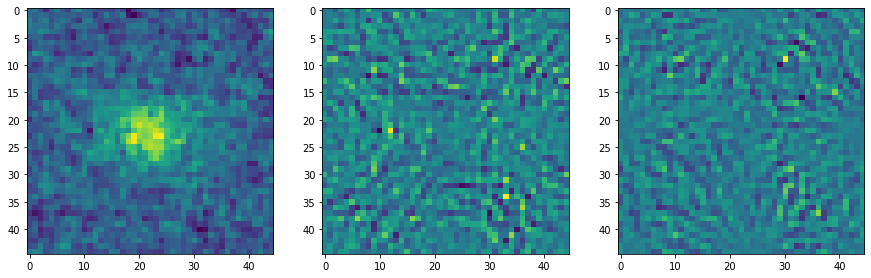

In [123]:
figure(figsize=[15,5])
subplot(131)
imshow(mcal[0])
subplot(132)
imshow(image_jacobian[0,:,:,0])
subplot(133)
imshow(image_jacobian[0,:,:,1])

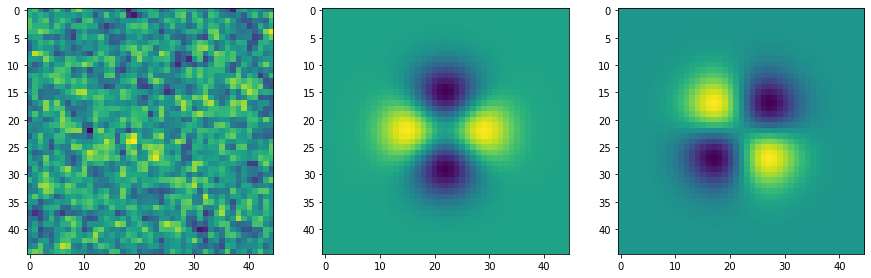

In [133]:
figure(figsize=[15,5])
subplot(131)
imshow(mcal[0])
subplot(132)
imshow(e_jacobian[0,0,:,:])
subplot(133)
imshow(e_jacobian[0,1,:,:])

In [225]:
@tf.function
def get_ellipticity_jacobian2(img):
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img)
        e = tf.reshape(get_ellipticity(img), [1,2])
        res = tape.batch_jacobian(e,img)
    return e, res

In [226]:
_, e_jacobian = get_ellipticity_jacobian2(gal+img0)

In [227]:
e_jacobian.shape

TensorShape([1, 2, 45, 45])

In [228]:
# # ok cool, so, now... question is whether we can estimate the bias term 
# @tf.custom_gradient
# def myellipticit(img):
#     def backward(dy):
#         e_jac = get_ellipticity_jacobian2(gal+img)
#         return tf.tensordot(dy,e_jacobian,[[1],[1]])[:,0]
#     return tf.reshape(get_ellipticity(y[0]),[1,2]), backward

In [233]:
@tf.function
def get_custom_response(img):
    img = tf.convert_to_tensor(img)
    g = tf.zeros([1,2])
    
    @tf.custom_gradient
    def myellipt(y):
        def backward(dy):
            _, e_jac = get_ellipticity_jacobian2(gal+img)
            return tf.tensordot(dy,e_jac,[[1],[1]])[:,0]
        return tf.reshape(get_ellipticity(y[0]),[1,2]), backward
    
    with tf.GradientTape() as tape:
        tape.watch(g)
        tape.watch(img)
        imgn = noise_level*tf.random.normal(shape=[1,45,45])
        mcal = autometacal.generate_mcal_image(imgn, psf, reconv_psf, g)
        e = myellipt(mcal)
    res = tape.batch_jacobian(e,g)
    return mcal, e, res

In [207]:
# ok, so this works. Now, the thing we want to try, is to add random noise but just a given noise realisation in
# the first term, and see if it makes a significant difference

In [253]:
Rb = []
Rbt = []
for i in range(100000):
    img = noise_level*tf.random.normal(shape=[1,45,45])
    _,_, Rcustom = get_custom_response(img) # Estimate bias for a given image with noise sims
    _, _, Rn = get_response(img, gal) # Measure the de/di dI/dg(n) <- should be the source of bias
    
    Rb.append(Rcustom[0])
    Rbt.append(Rn[0])
Rb = np.stack(Rb, axis=0)
Rbt = np.stack(Rbt, axis=0)

In [254]:
Rb.mean(axis=0)

array([[-0.00011126, -0.00017324],
       [-0.00013196,  0.00012943]], dtype=float32)

In [255]:
Rbt.mean(axis=0)

array([[-1.0414132e-03,  2.5893329e-04],
       [ 1.1139308e-05, -1.9840040e-04]], dtype=float32)

In [260]:
abs(Rb.mean(axis=0) - Rbt.mean(axis=0))/abs(Rbt.mean(axis=0))

array([[ 0.8931686,  1.6690476],
       [12.846037 ,  1.6523478]], dtype=float32)

In [261]:
Rcustom

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[0.02125852, 0.03019539],
        [0.00965834, 0.01128462]]], dtype=float32)>

In [262]:
Rn

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[ 0.00478487, -0.00396352],
        [-0.01330478, -0.05332007]]], dtype=float32)>